In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import xarray as xa
from pprint import pprint

fdir = "/home/jungyoung/Project_win/hh_neuralnet/"

import sys
sys.path.append('/home/jungyoung/Project/hh_neuralnet/include/')
import hhtools
import hhsignal

import hhclustering as hc
import utils 
import scipy

from importlib import reload
reload(utils)

from tqdm.notebook import tqdm, trange
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_mutual_info_score
from numba import njit

In [78]:
def get_base_idx(ne):
    return 16*ne + np.arange(16)
    

summary_obj = hhtools.SummaryLoader("../three_pop_mpi/simulation_data/data", load_only_control=True)
cid_dataset = xa.load_dataset("./data/cluster_id_update_sub.nc")
cid_flat = cid_dataset.cluster_id.data.flatten()

with open("./data/align_data_sub.pkl", 'rb') as fp:
    align_data = pkl.load(fp)
echelon = np.array([c["rank"] for c in align_data["col_names"]])
data_partial = align_data["data"][:-2, :]
lb_partial = align_data["row_labels"][:-2]
num_lb = len(lb_partial)

# Find representative point

In [257]:
repr_locs = dict(key_names=("alpha", "beta", "echelon", "w"),
                 nbest=nbest,
                 loc=[[] for i in range(10)])

for target_id in range(1, 10):
    idx = np.array(np.where(cid_dataset.cluster_id == target_id))
    sval_sub = np.array([cid_dataset.sval.data[idx[0][i], idx[1][i], idx[2][i], idx[3][i]] for i in range(len(idx[0]))])
    w = (sval_sub - np.min(sval_sub)) / (np.max(sval_sub) - np.min(sval_sub))

    w_sort = np.sort(w)[::-1]
    idx_sort = idx[:, np.argsort(w)[::-1]]
    
    # nbest = 300
    # nbest = 50
    nbest = int(0.1 * len(sval_sub))
    wsum = 0
    idx_center = np.zeros(4)
    for n in range(nbest):
        idx_center += idx_sort[:, n] * w_sort[n]
    idx_center = np.round(idx_center / nbest)

    repr_locs["loc"][target_id] = idx_center

with open("./data/cluster_repr_points.pkl", "wb") as fp:
    pkl.dump(repr_locs, fp)

In [293]:
for i in range(1, 10):
    loc = np.array(repr_locs["loc"][i], dtype=int)
    print("%.2f, %.2f, %.1f, %f"%(summary_obj.controls["alpha_set"][loc[0]], summary_obj.controls["beta_set"][loc[1]], summary_obj.controls["rank_set"][loc[2]], summary_obj.controls["p_ratio_set"][loc[3]]))

0.29, 0.07, 0.0, 0.600000
0.71, 0.64, 0.0, 0.000000
1.29, 0.57, 0.0, 0.850000
1.14, 0.21, 0.5, 0.000000
1.14, 0.71, 1.0, 0.900000
1.00, 0.71, 0.5, -0.100000
0.86, 0.79, 1.0, -0.300000
0.43, 0.07, 1.0, 0.450000
0.57, 0.43, 1.0, -0.500000


# Show representative dynamics

In [ ]:
tp_labels = ("Fast", "Slow")

for target_id in range(1, 10): # target_id = 8

    idx = np.where(cid_dataset.cluster_id == target_id)
    sval_sub = np.array([cid_dataset.sval.data[idx[0][i], idx[1][i], idx[2][i], idx[3][i]] for i in range(len(idx[0]))])
    
    nmax = np.argmax(sval_sub)
    idx_max = [n[nmax] for n in idx]
    
    detail_data = summary_obj.load_detail(*repr_locs["loc"][target_id], 0)
    idx_max_flat = int(summary_obj.get_id(*repr_locs["loc"][target_id], 0) // 9)
    
    num_echelon, _ = np.histogram(echelon[cid_flat == target_id], [0, 1, 2, 3])
    num_echelon_dom = np.argmax(num_echelon)
    data_base = data_partial[:, get_base_idx(num_echelon_dom)].mean(axis=1)
    
    w = (sval_sub - np.min(sval_sub)) / (np.max(sval_sub) - np.min(sval_sub))
    data_partial_mean = np.average(data_partial[:, cid_flat==target_id] * w[None, :], axis=1)
    
    plt.figure(figsize=(10, 3))
    
    plt.axes(position=(0.1, 0.3, 0.5, 0.6))
    plt.plot(data_partial[:, cid_flat==target_id]-data_base[:, None], 'k', alpha=0.01)
    plt.plot(data_partial[:, idx_max_flat]-data_base, 'r')
    # plt.plot(data_partial[:, cid_flat==target_id].mean(axis=1)-data_base, 'r')
    # plt.plot(data_partial_mean-data_base, "r")
    plt.plot([-0.5, num_lb-0.5], [0, 0], 'k--', zorder=-1)
    plt.xticks(np.arange(num_lb), lb_partial, rotation=60, fontsize=10)
    plt.ylim([-5, 5])
    plt.xlim([-0.5, num_lb-0.5])
    plt.ylabel(r"$Z - Z_{\alpha=\beta=0}$", fontsize=14)
    
    ax_f = plt.axes(position=(0.68, 0.52, 0.22, 0.38))
    ax_s = plt.axes(position=(0.68, 0.05, 0.22, 0.38))
    for n, ax in enumerate([ax_f, ax_s]):
        plt.axes(ax)
        psd_t, fpsd, tpsd = hhsignal.get_stfft(detail_data["vlfp"][n+1], detail_data["ts"], fs=2000, mbin_t=0.1, wbin_t=0.5, frange=(5, 100))
        hhtools.imshow_xy(psd_t, x=tpsd, y=fpsd, cmap="jet", interpolation="bicubic", vmin=0.0, vmax=None)
        plt.xlim([0.5, 4.5])
        plt.xticks([])
        plt.ylabel("Frequency (Hz)", fontsize=10)        
        ob = hhtools.AnchoredHScaleBar(ax=ax, size=1, label="1 s", loc="lower left", frameon=False,
                            pad=0.08, sep=2, linecolor="w", fontcolor="w",
                            fontsize=12, fontstyle="italic")
        ax.add_artist(ob)
        plt.text(3.2, 80, tp_labels[n], color="w", fontsize=14, fontstyle="italic", fontweight="bold")
    
    # plt.show()
    plt.savefig("./figs/cluster_features/cid%d.png"%(target_id), bbox_inches="tight")

# Fequency change in each cluster

In [271]:
def _fft(detail):
    idt = detail["ts"] >= 0.5
    vlfp = detail["vlfp"][nt][idt]
    ts = detail["ts"][idt]
    fs = np.round(1/(ts[1] - ts[0]))

    # psd, fpsd, tpsd = hhsignal.get_stfft(vlfp, ts, fs, mbin_t=0.1, wbin_t=1, frange=(3, 120))
    psd, fpsd = hhsignal.get_fft(vlfp, fs, nbin_t=2, frange=(3, 200))
    return psd, fpsd


psd_set, psd_base_set = [], []
for cid in range(1, 10):
    psd_tot = [0, 0, 0]
    for i in range(9):
        detail = summary_obj.load_detail(*repr_locs["loc"][cid], i)
        for nt in range(3):    
            psd, fpsd = _fft(detail)
            psd_tot[nt] += psd/9
    psd_set.append(psd_tot)

    # base
    psd_base = [0, 0, 0]    
    nechelon = repr_locs["loc"][cid][2]
    
    for i in range(9):
        detail_base = sobj_base.load_detail(0, 0, nechelon, 0, i)
        for nt in range(3):
            psd_b, fpsd_b = _fft(detail_base)
            psd_base[nt] += psd_b/9
    psd_base_set.append(psd_base)

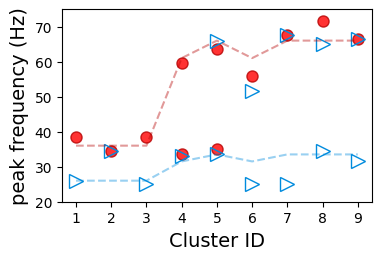

In [273]:
from scipy.signal import savgol_filter

plt.figure(figsize=(4, 2.5))

cset = ["k", "#b50202", "#008bdd"]
markers = ["", "o", ">"]

# fpeaks = [[] for _ in range(8)]
fpeaks_b = [[], [], []]

for nc in range(9):
    for nt in range(1, 3):
        yhat = savgol_filter(psd_set[nc][nt], 21, 1)
        npeaks = hhsignal.detect_peak(yhat, prominence=0.01, mode=0)
        
        # print("Cluster %d"%(nc+1))
        for n in npeaks:
            if nt == 1:
                plt.plot(nc+1, fpsd[n], markers[nt], color=cset[nt], markerfacecolor=[1, 0, 0, 0.8], markersize=8)
            if nt == 2:
                plt.plot(nc+1, fpsd[n], markers[nt], color=cset[nt], markerfacecolor="none", markersize=10)
            # print("%.3f"%(fpsd[n]))
            
        yhat_b = savgol_filter(psd_base_set[nc][nt], 21, 1)
        npeaks = hhsignal.detect_peak(yhat_b, prominence=0.02, mode=0)
        
        fpeaks_b[nt].append(fpsd[npeaks[0]])

fpeaks_b[1][-3] = fpeaks_b[1][-1]
fpeaks_b[2][-3] = fpeaks_b[2][-1]
        
plt.plot(np.arange(9)+1, fpeaks_b[1], '--', c=cset[1], alpha=0.4)
plt.plot(np.arange(9)+1, fpeaks_b[2], '--', c=cset[2], alpha=0.4)

plt.xticks(np.arange(1, 10))
plt.ylim([20, 75])

plt.xlabel("Cluster ID", fontsize=14)
plt.ylabel("peak frequency (Hz)", fontsize=14)

plt.show()